In [3]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

生成数据集

In [4]:
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100   # 训练数据集和测试数据集的大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train+n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))  # (n_train+n_test, max_degree)
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1)   # gamma(n) = (n-1)!
# labels的维度: (n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [5]:
# NumPyndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32)
                                           for x in [true_w, features, poly_features, labels]]

In [6]:
features[:2], poly_features[:2, :], labels[:2] 

(tensor([[2.2656],
         [2.4896]]),
 tensor([[1.0000e+00, 2.2656e+00, 2.5664e+00, 1.9381e+00, 1.0977e+00, 4.9740e-01,
          1.8781e-01, 6.0787e-02, 1.7215e-02, 4.3334e-03, 9.8176e-04, 2.0220e-04,
          3.8176e-05, 6.6530e-06, 1.0766e-06, 1.6261e-07, 2.3026e-08, 3.0686e-09,
          3.8623e-10, 4.6054e-11],
         [1.0000e+00, 2.4896e+00, 3.0991e+00, 2.5719e+00, 1.6008e+00, 7.9707e-01,
          3.3074e-01, 1.1763e-01, 3.6607e-02, 1.0126e-02, 2.5211e-03, 5.7061e-04,
          1.1838e-04, 2.2672e-05, 4.0317e-06, 6.6917e-07, 1.0412e-07, 1.5249e-08,
          2.1091e-09, 2.7636e-10]]),
 tensor([ 9.9520, 11.9398]))

对模型进行训练和测试

In [7]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)   # 损失总和，样本总数
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    
    return metric[0]/metric[1]  # 平均损失

In [8]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    """训练函数"""
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    # yscale='log' y轴坐标显示距离缩放
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', 
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch+1)%20 == 0:    # 每20轮画一次
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0076375  1.1633672 -3.4081223  5.650269 ]]


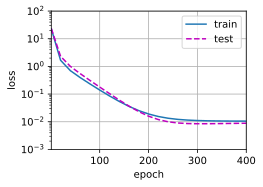

In [9]:
# 三阶多项式函数拟合(正常)
# 从多项式特征中选择前4个维度，即1、x、x^2/2!、x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[3.2455041 3.4696932]]


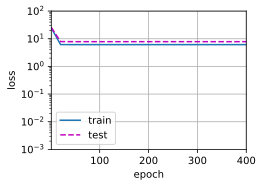

In [10]:
# 线性函数拟合(欠拟合)
# 从多项式特征中选择前两个维度, 即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 4.9867477   1.2238339  -3.287283    5.200538   -0.39453703  1.6640632
   0.1759742   0.0998078   0.1527152   0.1999718   0.03004961 -0.01348851
   0.12795383  0.15561554 -0.08488259  0.17919412 -0.15379739  0.14354897
  -0.12715966  0.14810705]]


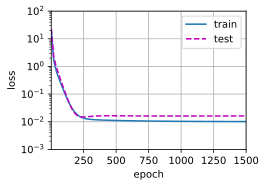

In [11]:
# 高阶多项式函数拟合(过拟合)
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)

练习 绘制多项式选择不同阶数下，与训练损失的关系图

In [12]:
def my_train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    """
    训练函数指定迭代轮数
    
    Returns
    ------------
        训练损失、测试损失
    """
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
   
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)

    return evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)

In [13]:
train_loss_record = []
test_loss_record = []

for weight_num in range(max_degree):
    train_loss, test_loss = my_train(poly_features[:n_train, :weight_num+1], poly_features[n_train:, :weight_num+1], 
                                     labels[:n_train], labels[n_train:], num_epochs=1000)
    train_loss_record.append(train_loss)
    test_loss_record.append(test_loss)

In [18]:
print('train_loss_record: ')
for train_loss in train_loss_record:
    print(f'{train_loss:.4f}', end=' ')
print('\ntest_loss_record')
for test_loss in test_loss_record:
    print(f'{test_loss:.4f}', end=' ')

train_loss_record: 
18.4531 6.1265 2.7505 0.0105 0.0110 0.0106 0.0100 0.0103 0.0102 0.0101 0.0101 0.0102 0.0102 0.0103 0.0101 0.0104 0.0102 0.0101 0.0103 0.0102 
test_loss_record
22.7447 7.8333 4.0375 0.0092 0.0101 0.0159 0.0139 0.0174 0.0165 0.0143 0.0156 0.0156 0.0147 0.0154 0.0152 0.0152 0.0155 0.0149 0.0159 0.0154 

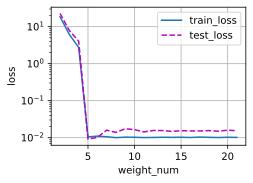

In [26]:
weight_nums = [i+1 for i in range(1, max_degree+1)]
d2l.plot(X=weight_nums, Y=[train_loss_record, test_loss_record], 
         xlabel='weight_num', ylabel='loss',
         legend=['train_loss', 'test_loss'],
         xscale='linear', yscale='log')